## 0. 성능 요약 (R >= 10) 인데이터 만 학습한 경우

LSTM(log적용) : r-squared : 0.45 (log를 적용안하면, 성능이 더 안좋음, peak를 잘 못맞춤)

LGBM : r-squared : 0.38 (log적용시 성능이 안좋음)


## 1. digital filter : separate from each component (base and run-off)

In [1]:
# 구글 드라이브 연결 (파일을 불러오기 위해 필요)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 딥러닝 모형 학습을 위한 기능 import
# -*- coding: utf-8 -*-
%tensorflow_version 1.x
import tensorflow as tf

import pandas as pd
import numpy as np

import datetime
import os
import glob

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.models import Model

from keras import layers
from keras.layers import *
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam, RMSprop

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats

from statsmodels.distributions.empirical_distribution import ECDF
!pip install h5py==2.10.0

%matplotlib inline
print(tf.__version__)

# 사용할 머신러닝 알고리즘 import

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR

from sklearn.metrics import r2_score


TensorFlow 1.x selected.


Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 8.8 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


1.15.2


In [3]:
# 구글 드라이브 파일경로(분석자마다 다르게 설정해야함)
path = '/content/drive/MyDrive/data/ten-day-inflow-avg/'

# 파일 읽기, 소양강 유역의 강우 및 유입량 데이터
df_input = pd.read_csv(path + 'soyang.csv')
df_input

,OBSYMD,DAMCD,RF,IQTY
0,19740101,1012110,0.0000,10.000
1,19740102,1012110,0.0000,9.000
2,19740103,1012110,0.0000,4.800
3,19740104,1012110,0.0000,6.100
4,19740105,1012110,0.0000,5.800
...,...,...,...,...
15985,20171007,1012110,0.1613,6.583
15986,20171008,1012110,0.0000,26.463
15987,20171009,1012110,0.0000,6.836
15988,20171010,1012110,1.9319,19.367


In [4]:
Q = df_input['IQTY'].to_numpy().flatten()
Q

array([10.   ,  9.   ,  4.8  , ...,  6.836, 19.367, 54.967])

In [5]:
a=0.95    #%baseflow filter parameter%

R = np.zeros(len(Q))
B = np.zeros(len(Q))
dif = np.zeros(len(Q))

for k in range(0, len(Q)-1):
  # 다음단계의 R은 현재 R * a와 Q의 변화량의 1/2 * (1+a)를 의미함
  #R(k+1)=a.*R(k)+((1+a).*(Q(k+1)-Q(k)))/2;
  R[k+1] = a * R[k] + ((1+a)*(Q[k+1] - Q[k]))/2
  
  # R이 0보다 작다면, 0으로 처리
  # if R(k+1)<0;
  #   R(k+1)=0;
  if R[k+1] < 0:
    R[k+1] = 0
  
  # R이 Q보다 크면 Q로 처리
  # if R(k+1)>Q(k+1);
  #   R(k+1)=Q(k+1);
  if R[k+1] > Q[k+1]:
    R[k+1] = Q[k+1]

  # B는 Q - R
  #B(k+1)=Q(k+1)-R(k+1);
  B[k+1] = Q[k+1] - R[k+1]

  # dif == R
  #dif(k+1)=Q(k+1)-B(k+1);
  dif[k+1] = Q[k+1] - B[k+1]

df = pd.DataFrame({'Q': Q, 'B': B, 'R': R, 'dif': dif, 'RF' : df_input['RF'] })
df

,Q,B,R,dif,RF
0,10.000,0.000000,0.000000,0.000000,0.0000
1,9.000,9.000000,0.000000,0.000000,0.0000
2,4.800,4.800000,0.000000,0.000000,0.0000
3,6.100,4.832500,1.267500,1.267500,0.0000
4,5.800,4.888375,0.911625,0.911625,0.0000
...,...,...,...,...,...
15985,6.583,6.583000,0.000000,0.000000,0.1613
15986,26.463,7.080000,19.383000,19.383000,0.0000
15987,6.836,6.836000,0.000000,0.000000,0.0000
15988,19.367,7.149275,12.217725,12.217725,1.9319


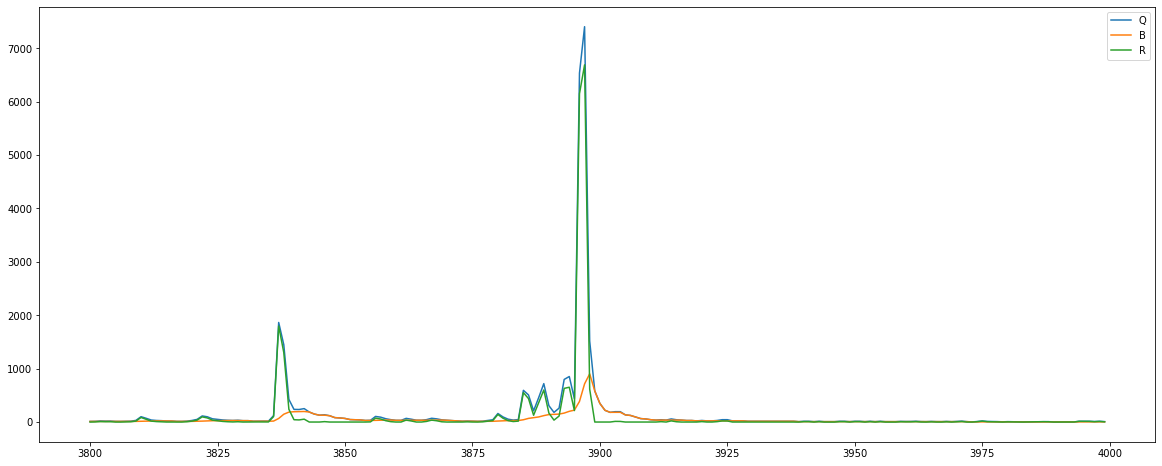

In [6]:
df[['Q', 'B', 'R']][3800:4000].plot(figsize=(20,8))

In [7]:
df.describe()

,Q,B,R,dif,RF
count,15990.000000,15990.000000,15990.000000,15990.000000,15990.000000
mean,68.907430,29.643463,39.263342,39.263342,3.333690
std,224.719975,50.379302,197.656138,197.656138,11.887878
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.200000,4.285312,0.066217,0.066217,0.000000
50%,20.000000,12.623876,4.337677,4.337677,0.000000
75%,51.000000,33.629863,13.649573,13.649573,0.800000
max,7405.600000,902.570875,6756.722944,6756.722944,268.700000


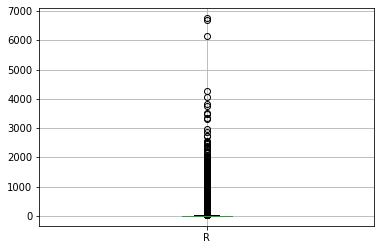

In [8]:
df[['R']].boxplot()

## 3-1. Predict surface flow using LSTM

## R > 10인 데이터만 훈련데이터로 활용
## log10 적용

dataset_y_reshaped = np.log10(dataset_y_reshaped + eps)

In [9]:
# 3차원 입력데이터를 만들기 위해 df_in이라는 데이터프레임으로 복사

df_in = df[['R', 'RF']].copy()

# 값들을 0~1로 Min-Max 정규화 처리함

# define scaler
# scaler = MinMaxScaler()
scaler = StandardScaler()

# fit scaler on the training dataset
scaler.fit(df_in.values)
# transform the training dataset
df_in_scaled = pd.DataFrame(scaler.transform(df_in.values), columns = df_in.columns)

# 30에 대해 2개의 변수를 가지는 2차원 데이터셋을 기본 형태로 하는 3차원데이터셋(2차원을 기본으로 하는 배열)을 생성
# y_shift는 이후 1일 후를 예측으로 함

x_range = 5
y_shift = 1
features = df_in_scaled.shape[1]
y_target_column = 'R'
R_threshold = 10

nb_samples = df_in_scaled.shape[0] - (x_range + y_shift - 1)

dataset_X_reshaped = np.zeros((nb_samples, x_range, features))
dataset_y_reshaped = np.zeros((nb_samples, y_shift))

j = 0
for i in range(nb_samples):
  # 결측이 있는 경우 데이터셋에서 제외처리
  if ((np.isnan(df_in_scaled[i:(i+x_range)].to_numpy()).sum()) > 0) | (np.isnan(df_in[y_target_column][i+x_range+y_shift-1]).sum() > 0) :
    continue 
  
  if y_target_column == 'R':
    if df_in[y_target_column][i+x_range+y_shift-1].reshape(-1).sum() < R_threshold:
      continue

  dataset_X_reshaped[j] = df_in_scaled[i:(i+x_range)].to_numpy()
  dataset_y_reshaped[j] = df_in[y_target_column][i+x_range+y_shift-1].reshape(-1)
  j = j + 1

dataset_X_reshaped = dataset_X_reshaped[0:j]
dataset_y_reshaped = dataset_y_reshaped[0:j]

print(dataset_X_reshaped.shape)
#print(dataset_X_reshaped)

print(dataset_y_reshaped.shape)
#print(dataset_y_reshaped)

#X_train, X_test, y_train, y_test = train_test_split(dataset_X_reshaped, dataset_y_reshaped, test_size=0.01)

# 15000번째 까지를 훈련데이터셋으로
# 그이후를 테스트데이터셋으로 구성함
X_train = dataset_X_reshaped[0:3000,:,:]
X_val = dataset_X_reshaped[3000:4000,:,:]
X_test = dataset_X_reshaped[4000:,:,:]

# log10 적용
eps = 0
dataset_y_reshaped = np.log10(dataset_y_reshaped + eps)

y_train = dataset_y_reshaped[0:3000]
y_val = dataset_y_reshaped[3000:4000]
y_test = dataset_y_reshaped[4000:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4922, 5, 2)
(4922, 1)
(3000, 5, 2)
(922, 5, 2)
(3000, 1)
(922, 1)


## LSTM 하이퍼파라멘터
## 노드수 : 다음함수에서 node수를 변경 LSTM(node)(inputs)
## 중첩수 : return_sequences dense layer 직전은 false로 나머지는 true로 셋팅



In [11]:
# 기본 lstm모형을 생성
# lstm 은 stacked lstm형태로, stacked될 경우 return_sequence = TRUE 옵션 필요
# training=True옵션을 통해 dropout을 이용하여 매번 다른 결과값이 생성됨
# early stopping을 적용하여, 최적의 epoch를 결정함
# 현재 patience는 5로 설정되어 있음

def base_lstm(X_train, y_train, verbose = 1):
  inputs = Input(shape = (X_train.shape[1],X_train.shape[2]), name='inputs')
  x = LSTM(8, return_sequences=True)(inputs) 
  x = LSTM(8, return_sequences=False)(x) 
  output = Dense(units = 1, activation='linear', name='OUTPUT')(x)
  model = Model(inputs=inputs, outputs=output)

  opt = Adam()

  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  
  epc = 1000
  es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
  
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=epc, verbose=verbose, callbacks=[es], 
                      batch_size=8)
  return model
 
model_base = base_lstm(X_train, y_train)

Train on 3000 samples, validate on 1000 samples
Epoch 1/1000
3000/3000 [==============================] - 3s 959us/step - loss: 0.6754 - mae: 0.5919 - val_loss: 0.1553 - val_mae: 0.2992
Epoch 2/1000
3000/3000 [==============================] - 2s 732us/step - loss: 0.1360 - mae: 0.2786 - val_loss: 0.1073 - val_mae: 0.2416
Epoch 3/1000
3000/3000 [==============================] - 2s 724us/step - loss: 0.1092 - mae: 0.2449 - val_loss: 0.0980 - val_mae: 0.2231
Epoch 4/1000
3000/3000 [==============================] - 2s 739us/step - loss: 0.1059 - mae: 0.2402 - val_loss: 0.0974 - val_mae: 0.2321
Epoch 5/1000
3000/3000 [==============================] - 3s 1ms/step - loss: 0.1048 - mae: 0.2383 - val_loss: 0.0969 - val_mae: 0.2143
Epoch 6/1000
3000/3000 [==============================] - 4s 1ms/step - loss: 0.1034 - mae: 0.2362 - val_loss: 0.0947 - val_mae: 0.2261
Epoch 7/1000
3000/3000 [==============================] - 3s 1ms/step - loss: 0.1024 - mae: 0.2346 - val_loss: 0.0933 - val_mae:

In [12]:
y_pred = np.power(10, model_base.predict(X_test) - eps) 
y_obs = np.power(10,y_test - eps) 

#y_pred = model_base.predict(X_test)
#y_obs = y_test

In [13]:
#df_pred = pd.DataFrame({'Date' : df_input['OBSYMD'][15005:].values, 'Obs' : y_obs.flatten(), 'Pred' : y_pred.flatten(), 'RF' : df_input['RF'][15005:].values})
#df_pred['Date'] = df_pred['Date'].apply(lambda x: pd.to_datetime(str(int(x)), format='%Y%m%d')) 
df_pred = pd.DataFrame({'Obs' : y_obs.flatten(), 'Pred' : y_pred.flatten()})

df_pred

,Obs,Pred
0,20.555486,43.041477
1,23.723137,31.307224
2,17.309990,20.091583
3,34.622390,49.379509
4,81.509646,45.963364
...,...,...
917,16.946802,22.435478
918,12.529725,16.520500
919,19.383000,16.859240
920,12.217725,16.838552


In [14]:
r2=r2_score(df_pred['Obs'].to_numpy(), df_pred['Pred'].to_numpy())
r2

0.4516287205564288

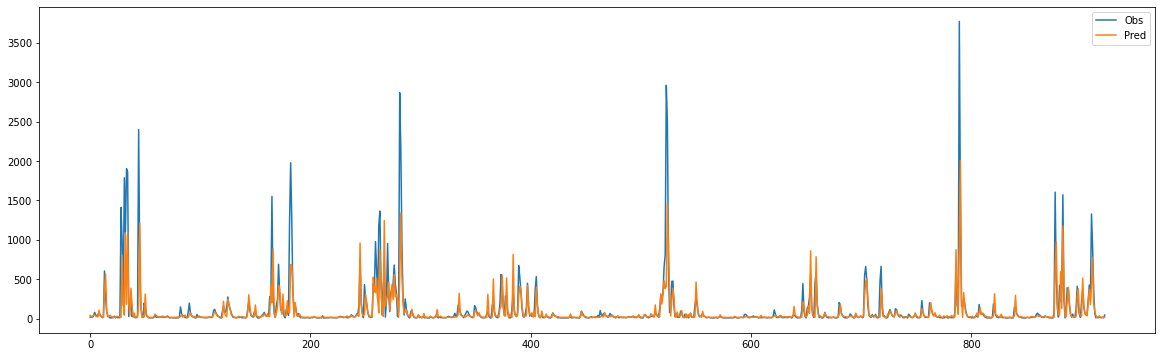

In [15]:
df_pred[['Obs', 'Pred']].plot(figsize=(20,6))

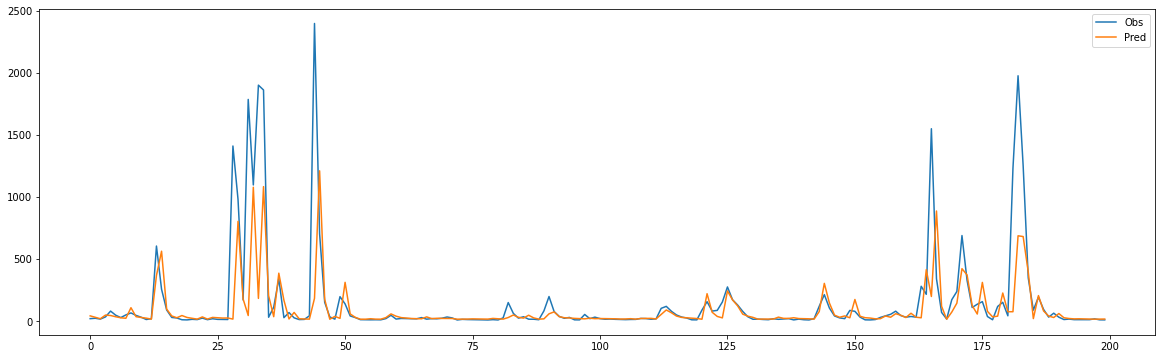

In [16]:
df_pred[['Obs', 'Pred']][0:200].plot(figsize=(20,6))

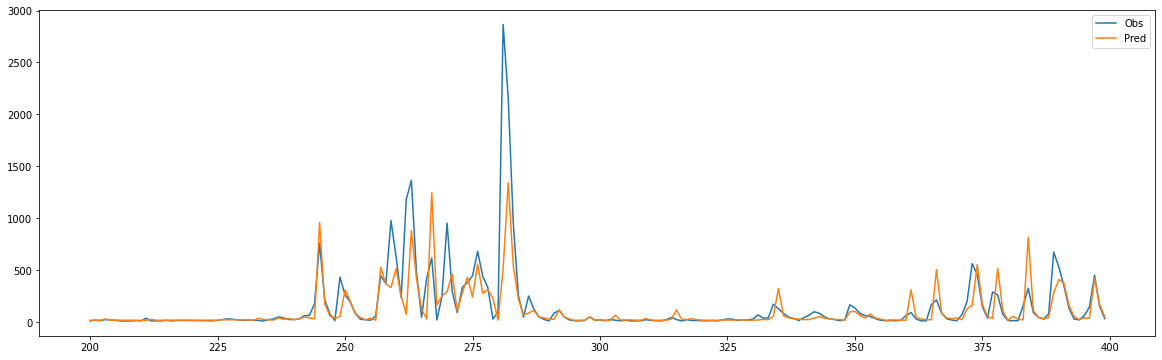

In [17]:
df_pred[['Obs', 'Pred']][200:400].plot(figsize=(20,6))

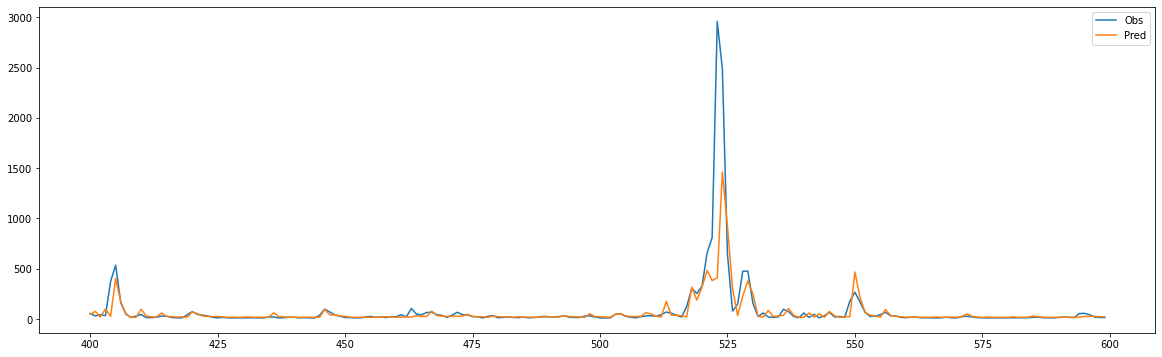

In [18]:
df_pred[['Obs', 'Pred']][400:600].plot(figsize=(20,6))

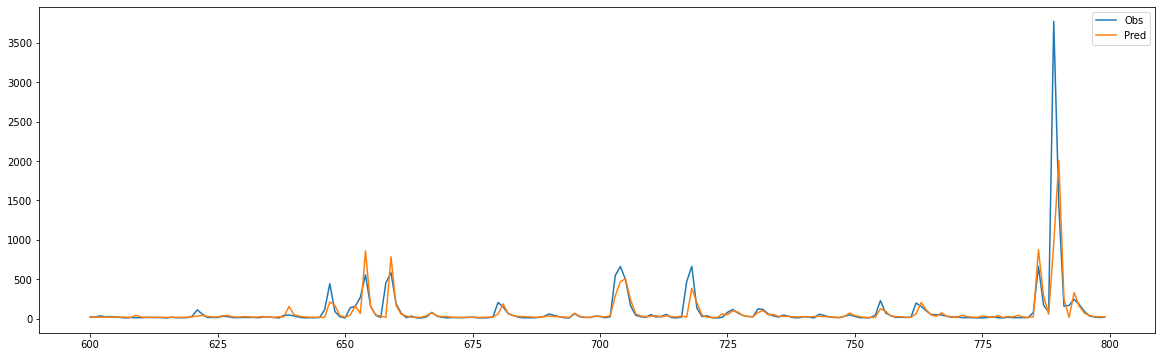

In [19]:
df_pred[['Obs', 'Pred']][600:800].plot(figsize=(20,6))

# 3-2. Predict Surface flow using other statistics & ML algorithm

In [22]:
# 시계열에 대한 Lag변수를 만들기 위한 함수
def buildLaggedFeatures(s,lag=2,dropna=True):

# Builds a new DataFrame to facilitate regressing over all possible lagged features
  if type(s) is pd.DataFrame:
    new_dict={}
    for col_name in s:
        new_dict[col_name]=s[col_name]
        # create lagged Series
        for l in range(1,lag+1):
            new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
    res=pd.DataFrame(new_dict,index=s.index)

  elif type(s) is pd.Series:
    the_range=range(lag+1)
    res=pd.concat([s.shift(i) for i in the_range],axis=1)
    res.columns=['lag_%d' %i for i in the_range]
  else:
    print('Only works for DataFrame or Series')
    return None
  if dropna:
    return res.dropna()
  else:
    return res 

# 강우에 대한 30일간의 Lag변수 생성
rf_30 = buildLaggedFeatures(df[['RF']],30)

# base flow 유입량에 대한 30일간의 Lag변수 생성
b_30 = buildLaggedFeatures(df[['R']],30)

# 30일간의 lag된 강우와, 30일째 유입량을 변수로 만듬
# RF(t-1) ~ RF(t-5)으로  Q(t)를 예측하는 문제로 설정함
data = pd.concat([rf_30.drop(columns=['RF']), b_30], axis=1)
data

,RF_lag1,RF_lag2,RF_lag3,RF_lag4,RF_lag5,RF_lag6,RF_lag7,RF_lag8,RF_lag9,RF_lag10,...,R_lag21,R_lag22,R_lag23,R_lag24,R_lag25,R_lag26,R_lag27,R_lag28,R_lag29,R_lag30
30,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,0.0000,8.0000,...,0.000000,0.789458,1.446798,4.191367,3.693544,0.911625,1.267500,0.000000,0.000000,0.000000
31,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,0.0000,...,1.560000,0.000000,0.789458,1.446798,4.191367,3.693544,0.911625,1.267500,0.000000,0.000000
32,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,...,0.897000,1.560000,0.000000,0.789458,1.446798,4.191367,3.693544,0.911625,1.267500,0.000000
33,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,...,2.802150,0.897000,1.560000,0.000000,0.789458,1.446798,4.191367,3.693544,0.911625,1.267500
34,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,...,2.564542,2.802150,0.897000,1.560000,0.000000,0.789458,1.446798,4.191367,3.693544,0.911625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15985,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,0.0000,0.0679,1.6041,...,0.000000,0.000000,0.000000,0.000000,5.392647,19.104786,0.044801,0.020475,0.000000,6.337500
15986,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,0.0000,0.0679,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.392647,19.104786,0.044801,0.020475,0.000000
15987,0.0000,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.392647,19.104786,0.044801,0.020475
15988,0.0000,0.0000,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,...,12.532650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.392647,19.104786,0.044801


In [29]:
data.drop(data[data.R < 10].index, inplace=True)
data = data.reset_index(drop=True)
data

,RF_lag1,RF_lag2,RF_lag3,RF_lag4,RF_lag5,RF_lag6,RF_lag7,RF_lag8,RF_lag9,RF_lag10,...,R_lag21,R_lag22,R_lag23,R_lag24,R_lag25,R_lag26,R_lag27,R_lag28,R_lag29,R_lag30
0,16.5000,2.3000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,...,2.998060,3.258484,1.274720,0.726021,0.969496,1.841575,2.143763,2.153961,5.962064,4.120594
1,1.3000,16.5000,2.3000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,...,1.873157,2.998060,3.258484,1.274720,0.726021,0.969496,1.841575,2.143763,2.153961,5.962064
2,0.0000,1.3000,16.5000,2.3000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,...,4.801999,1.873157,2.998060,3.258484,1.274720,0.726021,0.969496,1.841575,2.143763,2.153961
3,3.5000,0.0000,1.3000,16.5000,2.3000,0.000,0.0000,0.0000,0.0000,0.0000,...,4.269399,4.801999,1.873157,2.998060,3.258484,1.274720,0.726021,0.969496,1.841575,2.143763
4,0.0000,3.5000,0.0000,1.3000,16.5000,2.300,0.0000,0.0000,0.0000,0.0000,...,4.835929,4.269399,4.801999,1.873157,2.998060,3.258484,1.274720,0.726021,0.969496,1.841575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4917,0.2752,18.9202,0.0000,0.4728,0.0000,0.000,0.0000,0.0655,0.0000,14.5532,...,0.000000,0.000000,12.785175,0.000000,62.085079,357.355978,913.488740,1327.714490,256.841121,426.870180
4918,0.0679,1.6041,0.0830,0.0000,0.0000,0.000,0.0000,0.1049,0.2752,18.9202,...,0.000000,6.337500,0.000000,0.780000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4919,0.1613,2.7985,0.0000,0.0000,0.0000,3.248,2.0366,0.0000,0.0000,0.0679,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.392647,19.104786,0.044801,0.020475,0.000000
4920,0.0000,0.0000,0.1613,2.7985,0.0000,0.000,0.0000,3.2480,2.0366,0.0000,...,12.532650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.392647,19.104786,0.044801


In [30]:
# train dataset과 test dataset으로 분리
train = data[:4000]
test = data[4000:]

# 독립변수와 종속변수 분리
eps = 0

X_train = train.drop(['R'], axis = 1)
#y_train = np.log10(train['R'] + eps)
y_train = train['R']

X_test = test[X_train.columns]
#y_test = np.log10(test['R'] + eps)
y_test = test['R']


In [32]:
# 선형회귀, Lasso, Ridge, SVR, Randomforest, LGBM 모델을 설정하고, 위와 동일하게 반복 수행하며
# test dataset에 대한 r-squared 계산

models=[LinearRegression(), 
        Lasso(random_state=0), 
        Ridge(random_state=0),
        SVR(kernel='poly', degree = 2), 
        RandomForestRegressor(random_state=0), 
        LGBMRegressor(random_state=0)]
     
model_names=['LinearRegression',
             'Lasso', 
             'Ridge',
             'SVR_poly',
             'RandomForestRegressor',
             'LGBMRegressor']

r2_list=[]

for model in range (len(models)):
  print(model_names[model])
  clf=models[model]
  clf.fit(X_train,y_train)
  pred=clf.predict(X_test)
  #r2=r2_score(np.power(10, y_test.to_numpy()) - eps, np.power(10, pred) - eps)
  r2=r2_score(y_test.to_numpy(), pred)
  
  print(r2)
  r2_list.append(r2)
  

LinearRegression
0.4079365568690273
Lasso
0.4081221859328825
Ridge
0.40793667195736694
SVR_poly
0.1270154563468493
RandomForestRegressor
0.357460888075405
LGBMRegressor
0.38187938730012516


In [34]:
m_r=LGBMRegressor(random_state=0)
m_r.fit(X_train,y_train)
y_pred = m_r.predict(X_test)
y_obs = y_test
r2=r2_score(y_obs, y_pred)
r2



0.38187938730012516

In [36]:
df_pred_r = pd.DataFrame({'Obs' : y_obs, 'Pred' : y_pred})

df_pred_r

,Obs,Pred
4000,20.555486,40.908071
4001,23.723137,30.597936
4002,17.309990,69.197714
4003,34.622390,144.243506
4004,81.509646,63.514141
...,...,...
4917,16.946802,40.756802
4918,12.529725,21.595857
4919,19.383000,18.978309
4920,12.217725,12.943057


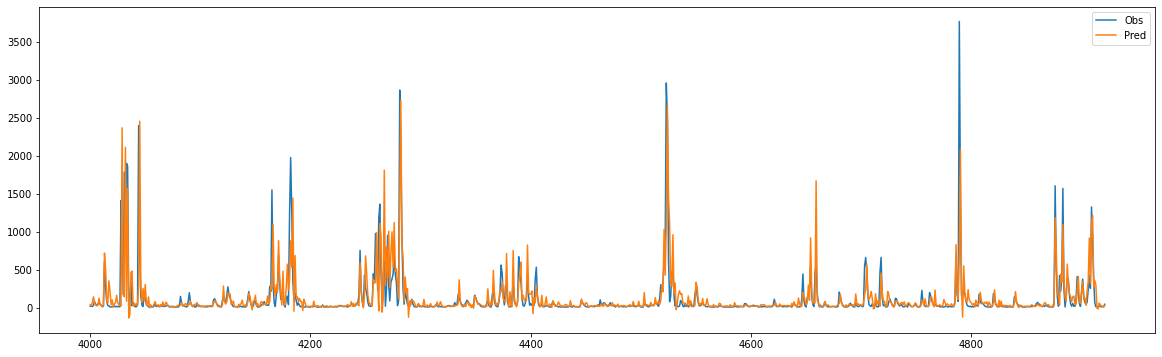

In [37]:
df_pred_r[['Obs', 'Pred']].plot(figsize=(20,6))

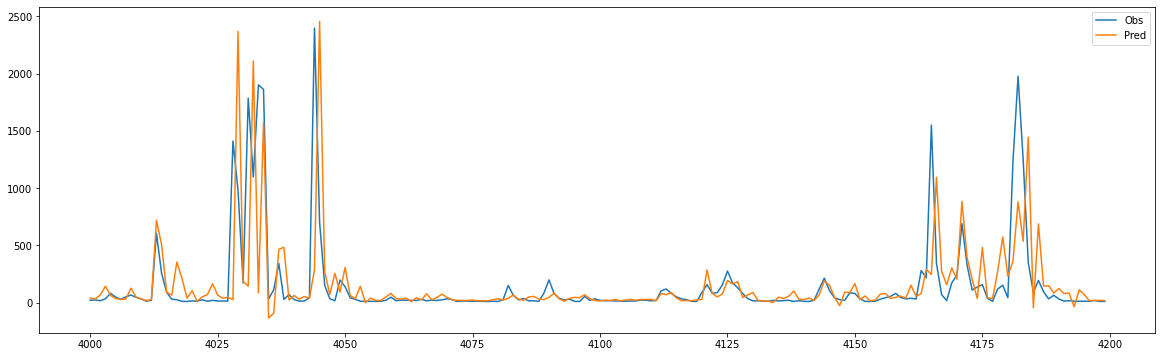

In [38]:
df_pred_r[['Obs', 'Pred']][0:200].plot(figsize=(20,6))

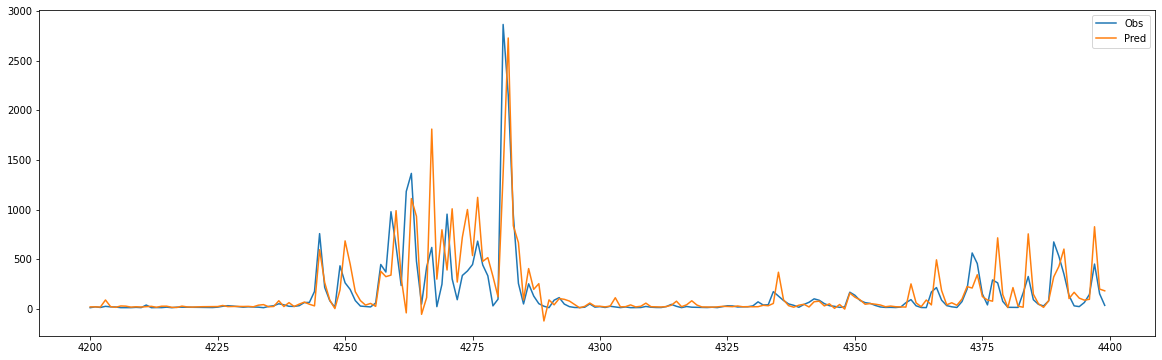

In [39]:
df_pred_r[['Obs', 'Pred']][200:400].plot(figsize=(20,6))

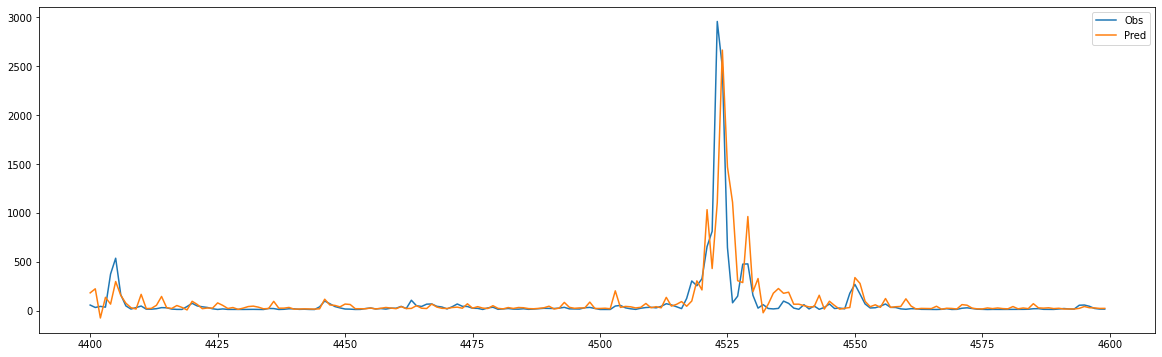

In [40]:
df_pred_r[['Obs', 'Pred']][400:600].plot(figsize=(20,6))

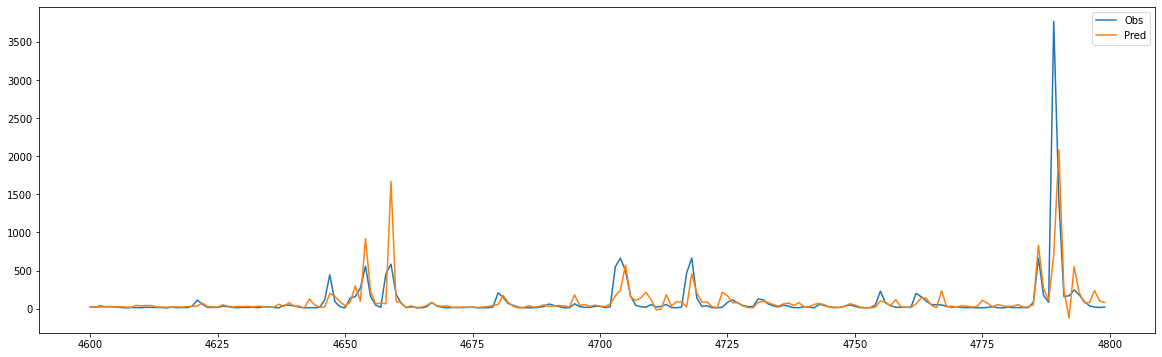

In [41]:
df_pred_r[['Obs', 'Pred']][600:800].plot(figsize=(20,6))